In [1]:
%%capture
!pip install scikit-plot
!pip install catboost
!pip install mlxtend
!pip install xgboost
!pip install lightgbm


import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scikitplot as skplt
import sklearn
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.decomposition import *
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier,
                              VotingClassifier)
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.tree import DecisionTreeClassifier

import lightgbm  # lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import xgboost  # xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
import catboost  # catboost.ai/docs/concepts/python-quickstart.html

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id','label'], axis = 1)

In [3]:
columns = combined_data.columns
categorical = ['attack_cat', 'proto', 'service', 'state']

for cat in categorical: 
  encoder = LabelEncoder()
  combined_data[cat] = encoder.fit_transform(combined_data[cat])

In [4]:
y = combined_data['attack_cat']
X = combined_data.drop(['attack_cat'], axis = 1) # inplace = true, to change-in place... mutate origianl data 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=42) 

categorical.remove('attack_cat')
train_categorical, test_categorical = X_train[categorical], X_test[categorical] 
X_train, X_test = X_train.drop(categorical, axis=1), X_test.drop(categorical, axis=1)

In [5]:
wanted_explained_variance_ratio = 0.99
steps_down = 2
wanted_n_components = X_train.shape[1]
first_time = True

for i in range(X_train.shape[1]-1, 1, -steps_down):
  total_var_ratio = round(np.sum(PCA(n_components=i).fit(X_train).explained_variance_ratio_), 5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False

print("We should set n_components to: ",wanted_n_components)

i = 38 with a variance ratio of 1.0
i = 36 with a variance ratio of 1.0
i = 34 with a variance ratio of 1.0
i = 32 with a variance ratio of 1.0
i = 30 with a variance ratio of 1.0
i = 28 with a variance ratio of 1.0
i = 26 with a variance ratio of 1.0
i = 24 with a variance ratio of 1.0
i = 22 with a variance ratio of 1.0
i = 20 with a variance ratio of 1.0
i = 18 with a variance ratio of 1.0
i = 16 with a variance ratio of 1.0
i = 14 with a variance ratio of 1.0
i = 12 with a variance ratio of 1.0
i = 10 with a variance ratio of 1.0
i = 8 with a variance ratio of 1.0
i = 6 with a variance ratio of 1.0
i = 4 with a variance ratio of 1.0
i = 2 with a variance ratio of 0.99275
We should set n_components to:  39


In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=wanted_n_components) # want 26ish to 28ish components, if you want 99% of variance explained
_ = pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [7]:
X_train, X_test = pd.DataFrame(X_train, index = train_categorical.index), pd.DataFrame(X_test, index = test_categorical.index)
X_train, X_test = pd.concat([X_train, train_categorical], axis=1), pd.concat([X_test, test_categorical], axis=1)

In [8]:
DTC = DecisionTreeClassifier(random_state=42) 
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=150, random_state=42, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(n_estimators=400, random_state=42, n_jobs=-1, objective='multiclass')

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs: 
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

## breaks convention, since Nystroem is used
# Linear_SVM = LinearSVC() # 0.77
# feature_map = Nystroem(n_components = 400, gamma= 0.99)
# _ = Linear_SVM.fit(feature_map.fit_transform(X_train), y_train)
# pred = Linear_SVM.score(feature_map.transform(X_test), y_test)
# print("Nystroem on LinearSVC:  %0.7f" %(pred))
# ranking.append(pred)

Acc: 0.72421 for the DecisionTreeClassifier
Acc: 0.77158 for the RandomForestClassifier
Acc: 0.76695 for the ExtraTreesClassifier
Acc: 0.77274 for the XGBClassifier
Acc: 0.77379 for the LGBMClassifier


In [9]:
#CAUTION: Very Expensive
CBC = catboost.CatBoostClassifier(eval_metric='AUC', use_best_model=True, random_seed=42) # loss_function - https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list
CBC.fit(X_train, y_train, eval_set=(X_test, y_test))
pred = CBC.score(X_test, y_test)
name = str(type(CBC)).split(".")[-1][:-2]
print("Acc: %0.5f for the %s" % (pred, name))

ranking.append(pred)
list_of_CLFs.append(CBC)
list_of_CLFs_names.append(name)

Learning rate set to 0.113639
0:	test: 0.8052312	best: 0.8052312 (0)	total: 253ms	remaining: 4m 12s
1:	test: 0.8308712	best: 0.8308712 (1)	total: 427ms	remaining: 3m 33s
2:	test: 0.8316269	best: 0.8316269 (2)	total: 637ms	remaining: 3m 31s
3:	test: 0.8475635	best: 0.8475635 (3)	total: 851ms	remaining: 3m 31s
4:	test: 0.8486388	best: 0.8486388 (4)	total: 1.05s	remaining: 3m 28s
5:	test: 0.8501425	best: 0.8501425 (5)	total: 1.26s	remaining: 3m 28s
6:	test: 0.8537029	best: 0.8537029 (6)	total: 1.44s	remaining: 3m 24s
7:	test: 0.8583415	best: 0.8583415 (7)	total: 1.65s	remaining: 3m 24s
8:	test: 0.8594933	best: 0.8594933 (8)	total: 1.84s	remaining: 3m 23s
9:	test: 0.8698663	best: 0.8698663 (9)	total: 2.04s	remaining: 3m 22s
10:	test: 0.8748131	best: 0.8748131 (10)	total: 2.23s	remaining: 3m 20s
11:	test: 0.8765891	best: 0.8765891 (11)	total: 2.43s	remaining: 3m 20s
12:	test: 0.8777466	best: 0.8777466 (12)	total: 2.62s	remaining: 3m 18s
13:	test: 0.8793780	best: 0.8793780 (13)	total: 2.83s	

115:	test: 0.9322669	best: 0.9323430 (113)	total: 23s	remaining: 2m 55s
116:	test: 0.9323090	best: 0.9323430 (113)	total: 23.2s	remaining: 2m 55s
117:	test: 0.9322996	best: 0.9323430 (113)	total: 23.4s	remaining: 2m 55s
118:	test: 0.9323510	best: 0.9323510 (118)	total: 23.6s	remaining: 2m 54s
119:	test: 0.9323168	best: 0.9323510 (118)	total: 23.8s	remaining: 2m 54s
120:	test: 0.9322962	best: 0.9323510 (118)	total: 24s	remaining: 2m 54s
121:	test: 0.9322881	best: 0.9323510 (118)	total: 24.2s	remaining: 2m 54s
122:	test: 0.9323678	best: 0.9323678 (122)	total: 24.4s	remaining: 2m 54s
123:	test: 0.9323891	best: 0.9323891 (123)	total: 24.6s	remaining: 2m 53s
124:	test: 0.9324575	best: 0.9324575 (124)	total: 24.8s	remaining: 2m 53s
125:	test: 0.9325461	best: 0.9325461 (125)	total: 25s	remaining: 2m 53s
126:	test: 0.9325078	best: 0.9325461 (125)	total: 25.2s	remaining: 2m 53s
127:	test: 0.9325678	best: 0.9325678 (127)	total: 25.4s	remaining: 2m 52s
128:	test: 0.9326615	best: 0.9326615 (128)	t

226:	test: 0.9350116	best: 0.9350431 (219)	total: 44.8s	remaining: 2m 32s
227:	test: 0.9350076	best: 0.9350431 (219)	total: 45.1s	remaining: 2m 32s
228:	test: 0.9350108	best: 0.9350431 (219)	total: 45.3s	remaining: 2m 32s
229:	test: 0.9350745	best: 0.9350745 (229)	total: 45.5s	remaining: 2m 32s
230:	test: 0.9350412	best: 0.9350745 (229)	total: 45.8s	remaining: 2m 32s
231:	test: 0.9350598	best: 0.9350745 (229)	total: 45.9s	remaining: 2m 32s
232:	test: 0.9350523	best: 0.9350745 (229)	total: 46.1s	remaining: 2m 31s
233:	test: 0.9350718	best: 0.9350745 (229)	total: 46.3s	remaining: 2m 31s
234:	test: 0.9350709	best: 0.9350745 (229)	total: 46.5s	remaining: 2m 31s
235:	test: 0.9350735	best: 0.9350745 (229)	total: 46.7s	remaining: 2m 31s
236:	test: 0.9350489	best: 0.9350745 (229)	total: 46.9s	remaining: 2m 31s
237:	test: 0.9350558	best: 0.9350745 (229)	total: 47.1s	remaining: 2m 30s
238:	test: 0.9350165	best: 0.9350745 (229)	total: 47.3s	remaining: 2m 30s
239:	test: 0.9349851	best: 0.9350745 (

338:	test: 0.9343406	best: 0.9350745 (229)	total: 1m 7s	remaining: 2m 10s
339:	test: 0.9343260	best: 0.9350745 (229)	total: 1m 7s	remaining: 2m 10s
340:	test: 0.9343465	best: 0.9350745 (229)	total: 1m 7s	remaining: 2m 10s
341:	test: 0.9343376	best: 0.9350745 (229)	total: 1m 7s	remaining: 2m 10s
342:	test: 0.9343501	best: 0.9350745 (229)	total: 1m 7s	remaining: 2m 9s
343:	test: 0.9343026	best: 0.9350745 (229)	total: 1m 7s	remaining: 2m 9s
344:	test: 0.9343036	best: 0.9350745 (229)	total: 1m 8s	remaining: 2m 9s
345:	test: 0.9343092	best: 0.9350745 (229)	total: 1m 8s	remaining: 2m 9s
346:	test: 0.9343204	best: 0.9350745 (229)	total: 1m 8s	remaining: 2m 9s
347:	test: 0.9342876	best: 0.9350745 (229)	total: 1m 8s	remaining: 2m 8s
348:	test: 0.9343116	best: 0.9350745 (229)	total: 1m 8s	remaining: 2m 8s
349:	test: 0.9342879	best: 0.9350745 (229)	total: 1m 9s	remaining: 2m 8s
350:	test: 0.9342952	best: 0.9350745 (229)	total: 1m 9s	remaining: 2m 8s
351:	test: 0.9343269	best: 0.9350745 (229)	tota

450:	test: 0.9338042	best: 0.9350745 (229)	total: 1m 29s	remaining: 1m 48s
451:	test: 0.9337962	best: 0.9350745 (229)	total: 1m 29s	remaining: 1m 48s
452:	test: 0.9338088	best: 0.9350745 (229)	total: 1m 29s	remaining: 1m 47s
453:	test: 0.9338124	best: 0.9350745 (229)	total: 1m 29s	remaining: 1m 47s
454:	test: 0.9337960	best: 0.9350745 (229)	total: 1m 29s	remaining: 1m 47s
455:	test: 0.9338072	best: 0.9350745 (229)	total: 1m 29s	remaining: 1m 47s
456:	test: 0.9338116	best: 0.9350745 (229)	total: 1m 30s	remaining: 1m 47s
457:	test: 0.9338017	best: 0.9350745 (229)	total: 1m 30s	remaining: 1m 46s
458:	test: 0.9337711	best: 0.9350745 (229)	total: 1m 30s	remaining: 1m 46s
459:	test: 0.9337613	best: 0.9350745 (229)	total: 1m 30s	remaining: 1m 46s
460:	test: 0.9337430	best: 0.9350745 (229)	total: 1m 30s	remaining: 1m 46s
461:	test: 0.9337543	best: 0.9350745 (229)	total: 1m 31s	remaining: 1m 46s
462:	test: 0.9337415	best: 0.9350745 (229)	total: 1m 31s	remaining: 1m 45s
463:	test: 0.9337275	best

561:	test: 0.9335420	best: 0.9350745 (229)	total: 1m 50s	remaining: 1m 26s
562:	test: 0.9335263	best: 0.9350745 (229)	total: 1m 50s	remaining: 1m 26s
563:	test: 0.9335220	best: 0.9350745 (229)	total: 1m 51s	remaining: 1m 25s
564:	test: 0.9335182	best: 0.9350745 (229)	total: 1m 51s	remaining: 1m 25s
565:	test: 0.9334932	best: 0.9350745 (229)	total: 1m 51s	remaining: 1m 25s
566:	test: 0.9334922	best: 0.9350745 (229)	total: 1m 51s	remaining: 1m 25s
567:	test: 0.9334984	best: 0.9350745 (229)	total: 1m 51s	remaining: 1m 25s
568:	test: 0.9334794	best: 0.9350745 (229)	total: 1m 52s	remaining: 1m 24s
569:	test: 0.9334856	best: 0.9350745 (229)	total: 1m 52s	remaining: 1m 24s
570:	test: 0.9334718	best: 0.9350745 (229)	total: 1m 52s	remaining: 1m 24s
571:	test: 0.9334682	best: 0.9350745 (229)	total: 1m 52s	remaining: 1m 24s
572:	test: 0.9334947	best: 0.9350745 (229)	total: 1m 52s	remaining: 1m 24s
573:	test: 0.9334703	best: 0.9350745 (229)	total: 1m 53s	remaining: 1m 23s
574:	test: 0.9334556	best

672:	test: 0.9331442	best: 0.9350745 (229)	total: 2m 12s	remaining: 1m 4s
673:	test: 0.9331408	best: 0.9350745 (229)	total: 2m 12s	remaining: 1m 4s
674:	test: 0.9331322	best: 0.9350745 (229)	total: 2m 13s	remaining: 1m 4s
675:	test: 0.9331294	best: 0.9350745 (229)	total: 2m 13s	remaining: 1m 3s
676:	test: 0.9331274	best: 0.9350745 (229)	total: 2m 13s	remaining: 1m 3s
677:	test: 0.9331502	best: 0.9350745 (229)	total: 2m 13s	remaining: 1m 3s
678:	test: 0.9331502	best: 0.9350745 (229)	total: 2m 13s	remaining: 1m 3s
679:	test: 0.9331355	best: 0.9350745 (229)	total: 2m 14s	remaining: 1m 3s
680:	test: 0.9331385	best: 0.9350745 (229)	total: 2m 14s	remaining: 1m 2s
681:	test: 0.9331327	best: 0.9350745 (229)	total: 2m 14s	remaining: 1m 2s
682:	test: 0.9331339	best: 0.9350745 (229)	total: 2m 14s	remaining: 1m 2s
683:	test: 0.9331063	best: 0.9350745 (229)	total: 2m 14s	remaining: 1m 2s
684:	test: 0.9330756	best: 0.9350745 (229)	total: 2m 15s	remaining: 1m 2s
685:	test: 0.9330815	best: 0.9350745 (

784:	test: 0.9325853	best: 0.9350745 (229)	total: 2m 38s	remaining: 43.5s
785:	test: 0.9325860	best: 0.9350745 (229)	total: 2m 39s	remaining: 43.4s
786:	test: 0.9325919	best: 0.9350745 (229)	total: 2m 39s	remaining: 43.2s
787:	test: 0.9325921	best: 0.9350745 (229)	total: 2m 39s	remaining: 43s
788:	test: 0.9326006	best: 0.9350745 (229)	total: 2m 40s	remaining: 42.8s
789:	test: 0.9326066	best: 0.9350745 (229)	total: 2m 40s	remaining: 42.6s
790:	test: 0.9325978	best: 0.9350745 (229)	total: 2m 40s	remaining: 42.4s
791:	test: 0.9325968	best: 0.9350745 (229)	total: 2m 40s	remaining: 42.3s
792:	test: 0.9326048	best: 0.9350745 (229)	total: 2m 41s	remaining: 42.1s
793:	test: 0.9326151	best: 0.9350745 (229)	total: 2m 41s	remaining: 41.9s
794:	test: 0.9326133	best: 0.9350745 (229)	total: 2m 41s	remaining: 41.7s
795:	test: 0.9326066	best: 0.9350745 (229)	total: 2m 42s	remaining: 41.5s
796:	test: 0.9326017	best: 0.9350745 (229)	total: 2m 42s	remaining: 41.3s
797:	test: 0.9325886	best: 0.9350745 (22

896:	test: 0.9324756	best: 0.9350745 (229)	total: 3m 5s	remaining: 21.3s
897:	test: 0.9324794	best: 0.9350745 (229)	total: 3m 5s	remaining: 21.1s
898:	test: 0.9324679	best: 0.9350745 (229)	total: 3m 6s	remaining: 20.9s
899:	test: 0.9324708	best: 0.9350745 (229)	total: 3m 6s	remaining: 20.7s
900:	test: 0.9324582	best: 0.9350745 (229)	total: 3m 6s	remaining: 20.5s
901:	test: 0.9324488	best: 0.9350745 (229)	total: 3m 6s	remaining: 20.3s
902:	test: 0.9324520	best: 0.9350745 (229)	total: 3m 6s	remaining: 20.1s
903:	test: 0.9324495	best: 0.9350745 (229)	total: 3m 7s	remaining: 19.9s
904:	test: 0.9324462	best: 0.9350745 (229)	total: 3m 7s	remaining: 19.7s
905:	test: 0.9324491	best: 0.9350745 (229)	total: 3m 7s	remaining: 19.5s
906:	test: 0.9324467	best: 0.9350745 (229)	total: 3m 7s	remaining: 19.3s
907:	test: 0.9324341	best: 0.9350745 (229)	total: 3m 8s	remaining: 19.1s
908:	test: 0.9324284	best: 0.9350745 (229)	total: 3m 8s	remaining: 18.8s
909:	test: 0.9324318	best: 0.9350745 (229)	total: 3

In [10]:
best = max(ranking)
avg = sum(ranking)/len(ranking)
variance = avg - best
to_remove = ranking - avg - variance
to_remove_alt = ranking - best - variance

print(list_of_CLFs_names)
print(to_remove)
print(to_remove_alt)

['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']
[-0.02738402  0.0199872   0.01535057  0.02114738  0.02218909  0.02564511]
[-0.04020657  0.00716464  0.00252802  0.00832482  0.00936653  0.01282256]


In [11]:
ranking = np.array(ranking)[to_remove > 0]
list_of_CLFs = np.array(list_of_CLFs)[to_remove > 0]

In [12]:
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))

Acc: 0.77809 for the EnsembleVoteClassifier


In [15]:
eclf_hard = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='hard')
eclf_hard.fit(X_train, y_train)
print("Acc: %0.5f for the %s" % (eclf_hard.score(X_test, y_test), str(type(eclf)).split(".")[-1][:-2]))

C:\Users\t954349\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acc: 0.77551 for the EnsembleVoteClassifier


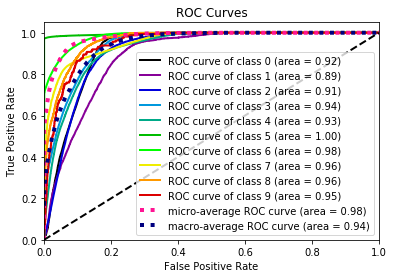

In [13]:
pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
skplt.metrics.plot_roc(y_true=y_test, y_probas=probas)
plt.show()

In [17]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## TODO type check
if type(y_test) is (pd.core.frame.DataFrame or pd.core.series.Series):
  y_test = y_test.values

def benchmark(y_test=y_test, pred=pred, pred_proba=None):
    from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, auc, roc_curve, roc_auc_score, hamming_loss, precision_score, recall_score, f1_score, log_loss

    print("Hamming_loss: \t\t", round(hamming_loss(y_test, pred), 3))                       # HL=1-Accuracy
    print("Precision_score: \t", round(precision_score(y_test, pred, average='micro'), 3))  # tp / (tp + fp)
    print("Recall_score: \t\t", round(recall_score(y_test, pred, average='micro'), 3))      # tp / (tp + fn)
    print("F1 score: \t\t", round(f1_score(y_test, pred, average='micro'), 3))              # 2 * (precision * recall) / (precision + recall)
    print("------------------------------")
    print("Accuracy_score: \t", round(accuracy_score(y_test, pred), 3))
    
    fpr, tpr, _ = roc_curve(y_test == 6, pred == 6)                                         # 6 is "Normal", rest are 'bad'
    print("False Positive Rate - binarized ", fpr)
    print("True Positive Rate  - binarized ", tpr)
    # roc_auc_score(y_test.values, pred, average="micro", multi_class = "ovo")
    print("Area of ROC: \t", round(auc(fpr, tpr), 3))                                       # Apx definite integral... of the ROC
    print("------------------------------")
    if pred_proba is not None: 
      # FYI, `is not` is an operator in it's own right. Like !=.
      print("Log loss (categorical cross entropy): \t", round(log_loss(y_test, pred_proba), 3))   # -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

benchmark(y_test, pred, probas)

sklearn.metrics.multilabel_confusion_matrix(y_test,pred)

Hamming_loss: 		 0.222
Precision_score: 	 0.778
Recall_score: 		 0.778
F1 score: 		 0.778
------------------------------
Accuracy_score: 	 0.778
False Positive Rate - binarized  [0.        0.0874399 1.       ]
True Positive Rate  - binarized  [0.        0.9263358 1.       ]
Area of ROC: 	 0.919
------------------------------
Log loss (categorical cross entropy): 	 0.611


array([[[241256,    984],
        [  2495,     55]],

       [[241706,    869],
        [  2150,     65]],

       [[220334,   8980],
        [ 10879,   4597]],

       [[184682,  17828],
        [ 11448,  30832]],

       [[213746,   7912],
        [ 12880,  10252]],

       [[188603,    350],
        [  1485,  54352]],

       [[142739,  13677],
        [  6510,  81864]],

       [[228058,   3414],
        [  5150,   8168]],

       [[243074,    270],
        [  1166,    280]],

       [[244590,     38],
        [   159,      3]]], dtype=int64)